# Recommender system using NMF

## Setup

In [84]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split            
from sklearn.model_selection import GridSearchCV
import re
import time

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
plt.style.use('ggplot')
sns.set_style('dark')
sns.set_palette('muted', color_codes=True)  
random_seed = 0
np.random.seed(random_seed)

In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
!kaggle datasets download -d odedgolden/movielens-1m-dataset -p data\movielens
with zipfile.ZipFile('data/movielens/movielens-1m-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/movielens')

<>:1: SyntaxWarning: invalid escape sequence '\k'
<>:1: SyntaxWarning: invalid escape sequence '\k'
C:\Users\cozie\AppData\Local\Temp\ipykernel_14148\178783147.py:1: SyntaxWarning: invalid escape sequence '\k'
  os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
movies = pd.read_csv('data/movielens/movies.dat', sep='::', header=None,
                     names=['movie_id', 'title', 'genres'], encoding='latin-1', engine='python')          
ratings = pd.read_csv('data/movielens/ratings.dat', sep='::', header=None,
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1', engine='python')
users = pd.read_csv('data/movielens/users.dat', sep='::', header=None,
                     names=['user_id', 'sex', 'age', 'occupation', 'zipcode'], encoding='latin-1', engine='python') 

## EDA

We have three dataframes: movies, users and ratings. 

### Movies

The movies dataframe contains the movieId, title and genres of 3883 movies

In [8]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Let's create a new column called year which contains the year of the movie release. Also we are going to clean the genres column by removing the pipe character and splitting the genres into a list. 

In [9]:
movies['year'] = movies['title'].str.extract(r'.*\((.*)\).*', expand=True)
movies['year'] = pd.to_datetime(movies['year'], format='%Y')
movies['year'] = movies['year'].dt.year
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '', regex=True)  
movies['genres'] = movies['genres'].str.split('|') 
movies              


<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\('
C:\Users\cozie\AppData\Local\Temp\ipykernel_14148\1441163417.py:4: SyntaxWarning: invalid escape sequence '\('
  movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '', regex=True)


,movie_id,title,genres,year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


Let's explore the number of movies released per year.

Text(0.5, 0, 'Year')

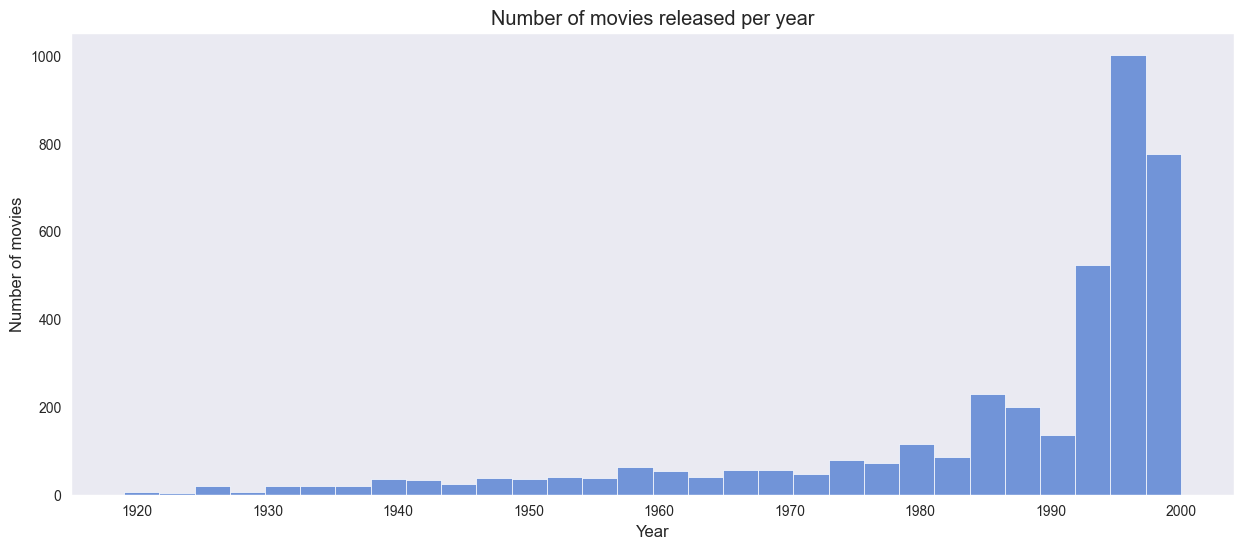

In [10]:
plt.figure(figsize=(15, 6))     
sns.histplot(movies['year'], bins=30, kde=False)                
plt.title('Number of movies released per year')             
plt.ylabel('Number of movies')
plt.xlabel('Year')  
    

The majority of the movies were released between 1990 and 2000.
Now let's explore the genres.

In [11]:
unique_genres = set()   
for movie_genres in movies['genres'].values:
    unique_genres.update(movie_genres)      
tmp = movies['genres'].str.join('|').str.get_dummies() 
movie_genres = pd.concat([movies[['movie_id', 'year']], tmp], axis=1)
movie_genres

,movie_id,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


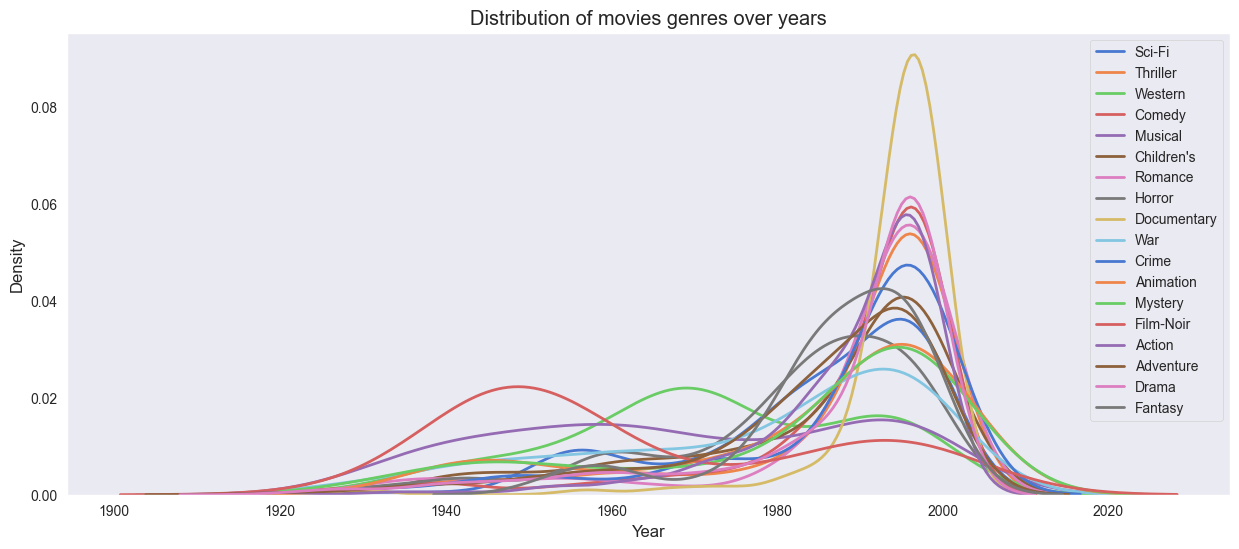

In [12]:
plt.figure(figsize=(15, 6))
for genre in unique_genres:
    tmp = movie_genres[movie_genres[genre] == 1]
    sns.kdeplot(tmp['year'], label=genre, linewidth=2)
plt.title('Distribution of movies genres over years')       
plt.ylabel('Density')
plt.xlabel('Year')  
plt.legend()  

There is a significant number of documentaries released around 1990. Some interesting findings are the number of sci-fi movies released around 1980 and the decline of children movies around 1960.

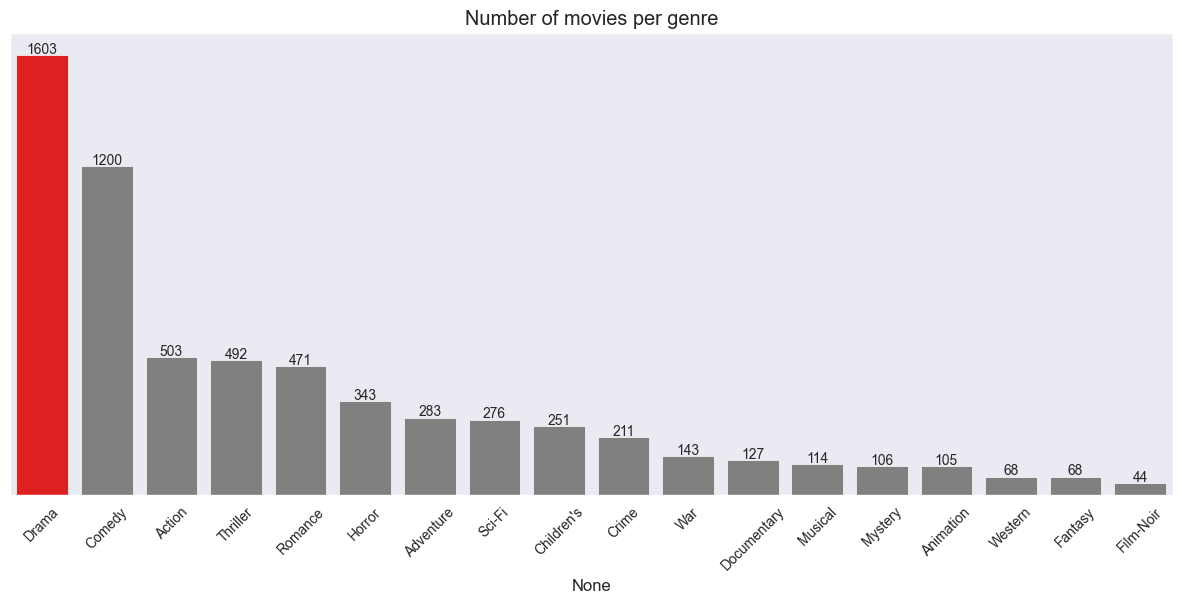

In [13]:
unique_genres = list(unique_genres)
tmp = movie_genres[unique_genres].sum(axis=0).sort_values(ascending=False)
colors = ['gray' if (x < max(tmp.values)) else 'red' for x in tmp.values]
plt.figure(figsize=(15, 6))
fig = sns.barplot(x=tmp.index, y=tmp.values, palette=colors)
plt.title('Number of movies per genre')
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+5,s='{:.0f}'.format(height), ha='center')
plt.tick_params(labelbottom=True, labelleft=False)
plt.xticks(rotation=45);



Most movies are classified as drama, comedy and action.

### Users

The users dataframe contains the user_id, sex, age and zipcode of 6040 users.

In [14]:
users

,user_id,sex,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


Let's explore the age distribution of the users.

<Axes: xlabel='age', ylabel='Count'>

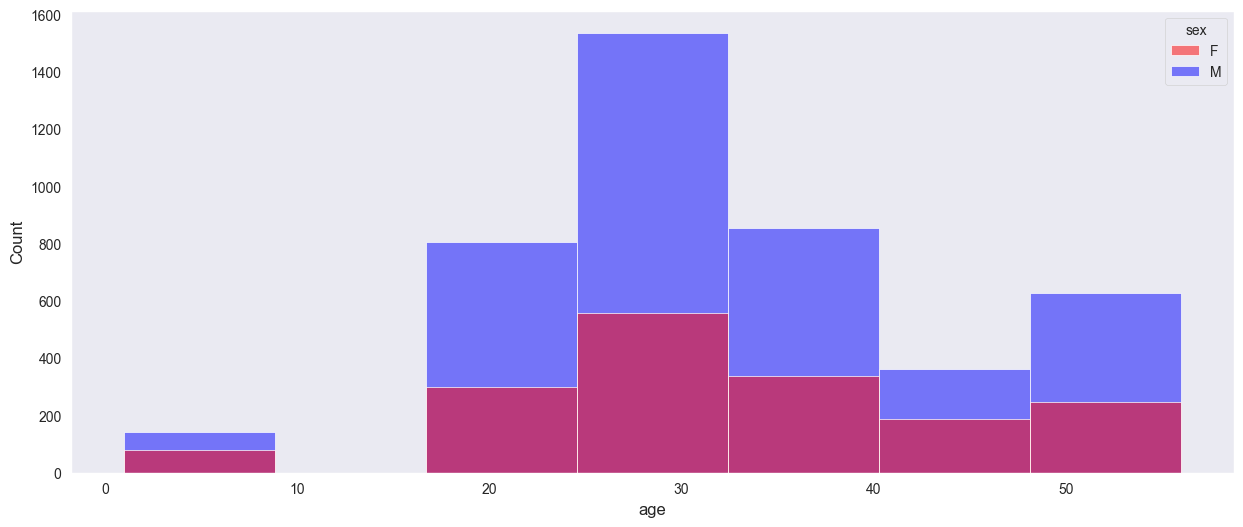

In [15]:
plt.figure(figsize=(15, 6))
sns.histplot(data=users, x='age', bins=7, kde=False, hue='sex', palette=['red','blue'])

Most users are between 18 and 50 years old. Also there is a significant amount of users who identified as male.

### Ratings

The ratings dataframe contains the user_id, movie_id, rating and timestamp of 1000209 ratings.

In [16]:
tmp = pd.merge(ratings, movie_genres, on='movie_id', how='left')
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


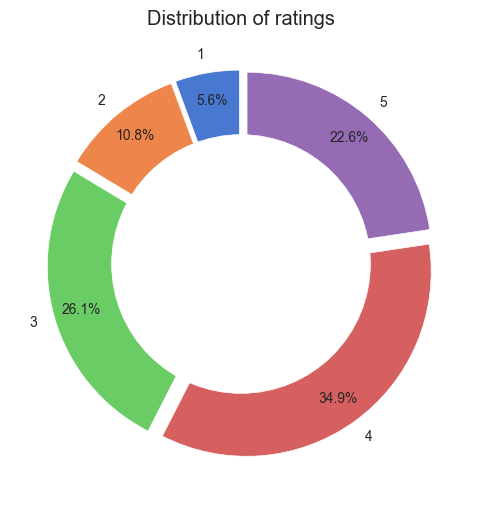

In [17]:

plt.figure(figsize=(15, 6))
data = tmp['rating'].value_counts().sort_index()    
plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=[0.05]*5)
plt.title('Distribution of ratings')
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

 


Most of the ratings can be considered positive, that could be because people tend to rate movies they like.
Let's explore the average rating per movie genre.

(0.0, 5.0)

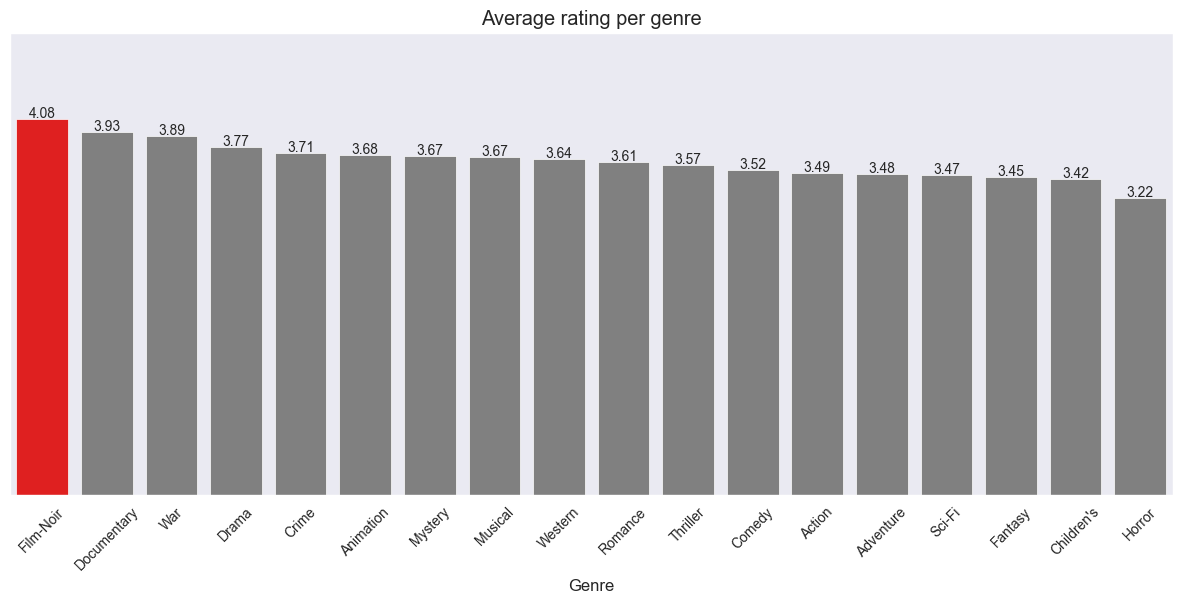

In [18]:
avg_ratings_by_genre = pd.DataFrame(columns=['genre', 'avg_rating'])    
for genre in unique_genres:
    tmp_= tmp[tmp[genre] == 1]
    # print(tmp_)
    avg_ratings_by_genre = pd.concat([avg_ratings_by_genre, pd.DataFrame([[genre, tmp_['rating'].mean()]], columns=['genre', 'avg_rating'])])
avg_ratings_by_genre = avg_ratings_by_genre.sort_values(by='avg_rating', ascending=False)
plt.figure(figsize=(15, 6)) 
colors = ['gray' if (x < max(avg_ratings_by_genre['avg_rating'].values)) else 'red' for x in avg_ratings_by_genre['avg_rating'].values] 
fig = sns.barplot(x='genre', y='avg_rating', data=avg_ratings_by_genre, palette=colors)
plt.title('Average rating per genre')
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+0.01,s='{:.2f}'.format(height), ha='center')
plt.tick_params(labelbottom=True, labelleft=False)
plt.ylabel('')
plt.xlabel('Genre')
plt.xticks(rotation=45);
plt.ylim(0,5)


Film-noir and documentary movies have the highest average rating. Now we are going to look how these average ratings evolved over time.

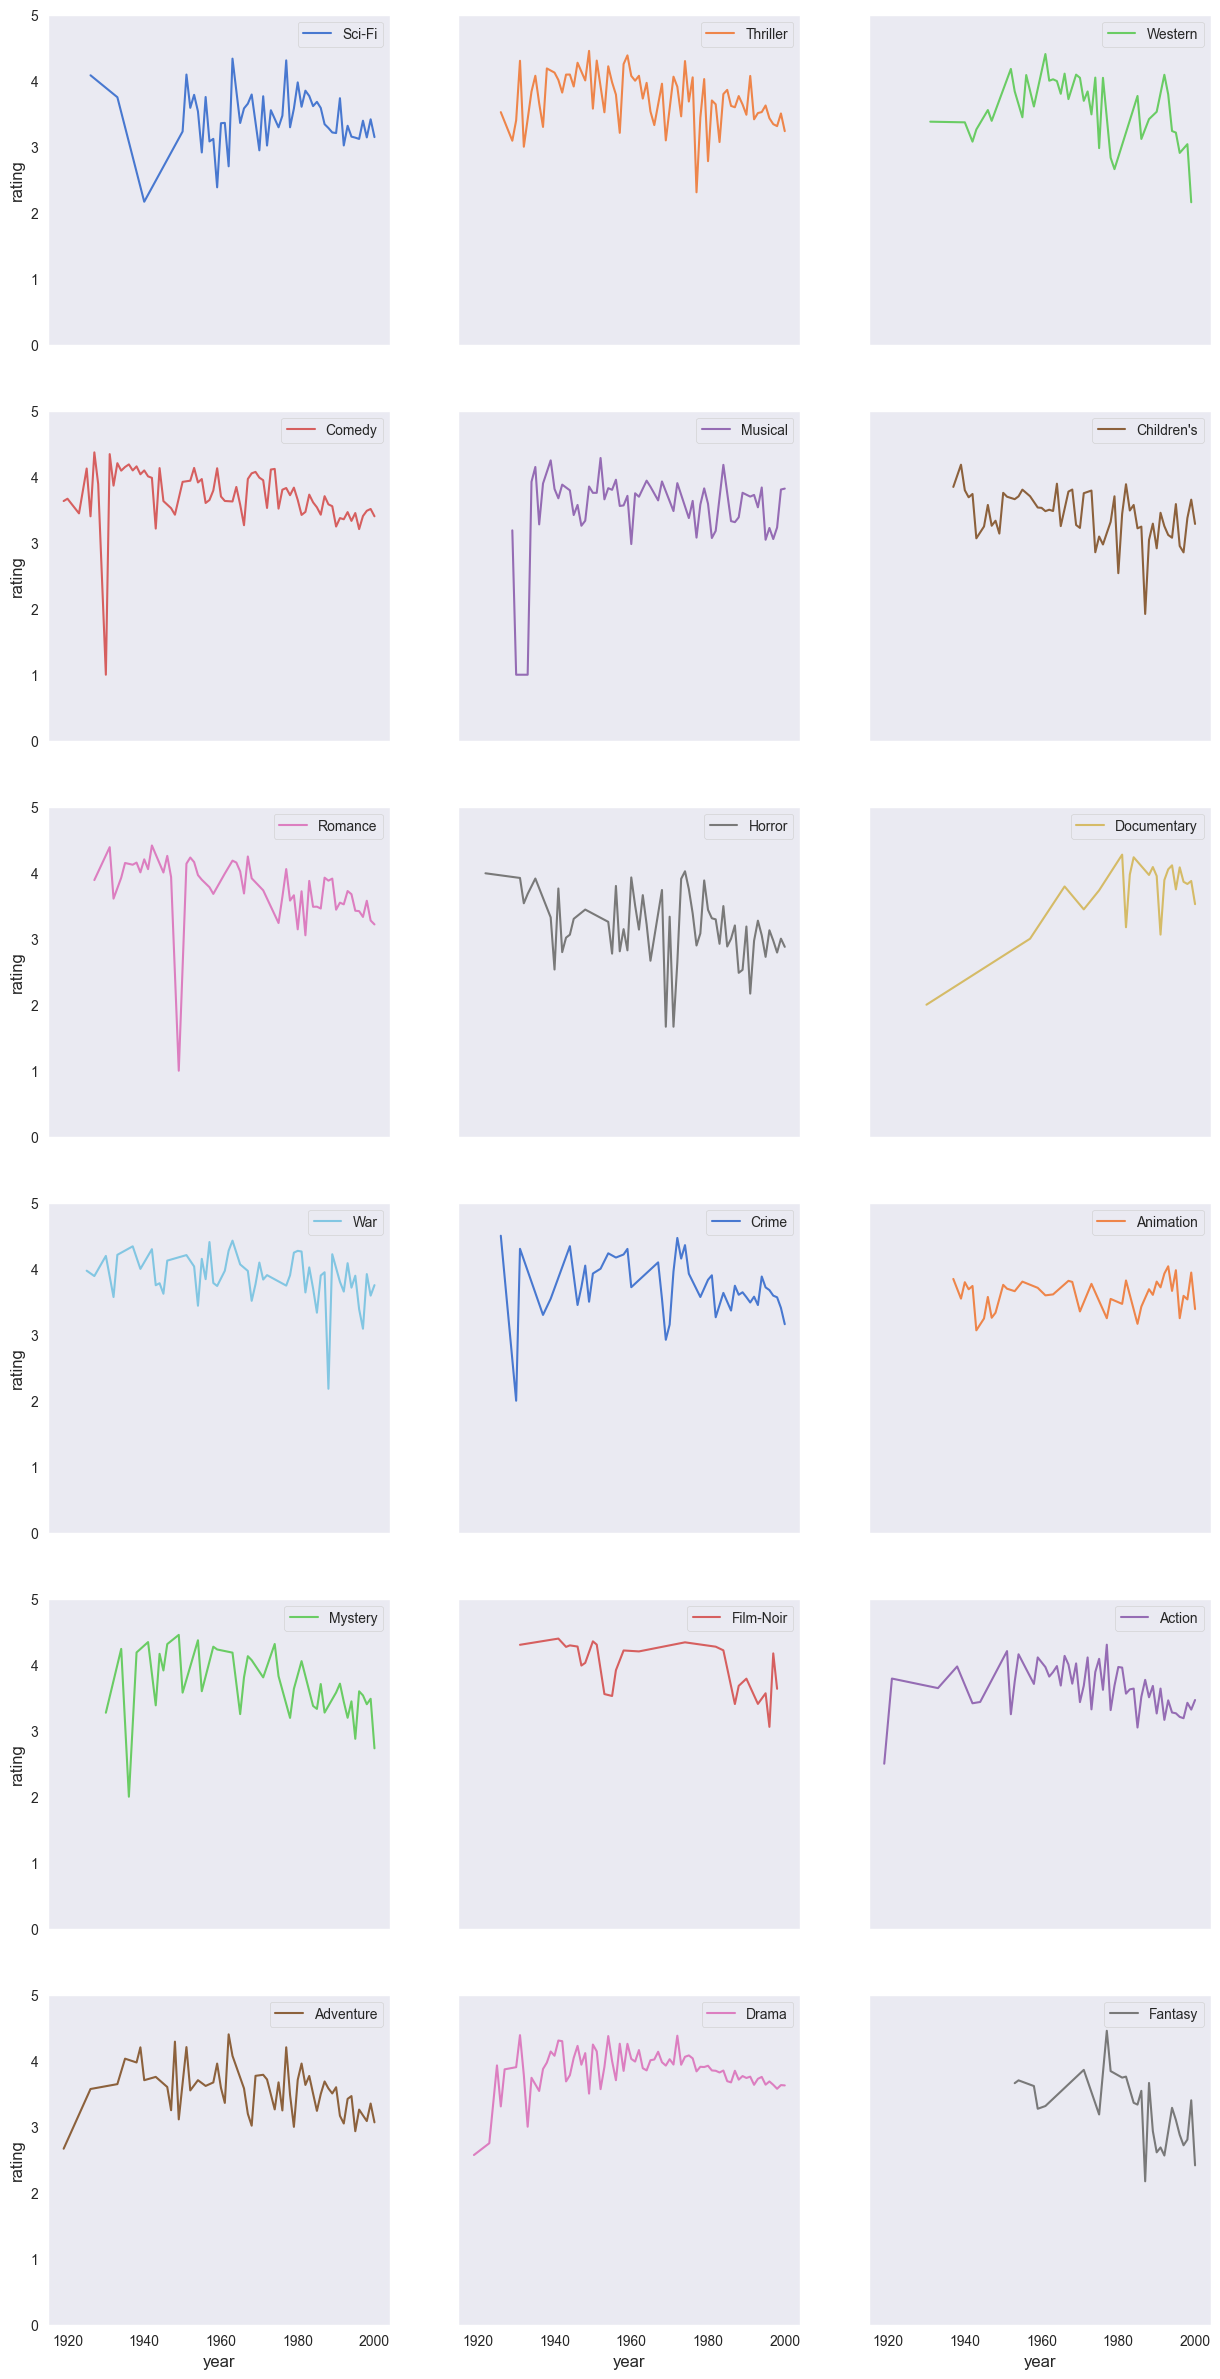

In [19]:
fig, axes = plt.subplots(6, 3, figsize=(15, 30), sharex=True, sharey=True)
plt.ylim(0,5)
colors = sns.color_palette("muted", n_colors=18)
for genre, ax, color in zip(unique_genres, axes.flatten(), colors):
    tmp_ = tmp[tmp[genre] == 1].groupby(['year']).agg({'rating': 'mean'}).reset_index()
    sns.lineplot(data=tmp_, x='year', y='rating', label=genre, ax=ax, color=color)
              

There is no clear trend in the average rating over time.

## Utility Matrix

The utility matrix is a matrix where each row represents a user and each column represents a movie. The values in the matrix are the ratings given by the users to the movies. It is a sparse matrix because most users have not rated most movies.

In [20]:
utility_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
print('Percentage of missing values: {:.2f}%'.format(utility_matrix.isnull().sum().sum() / (utility_matrix.shape[0] * utility_matrix.shape[1]) * 100))
utility_matrix

Percentage of missing values: 95.53%


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we fill the missing values with 0.

In [23]:
utility_matrix = utility_matrix.fillna(0)

## Train and Test Sets

We are going to split the utility matrix into train and test sets.

In [25]:
utility_matrix_train, utility_matrix_test = train_test_split(utility_matrix, test_size=0.05, random_state=random_seed)
utility_matrix_train.shape, utility_matrix_test.shape

((5738, 3706), (302, 3706))

Our train set contains 95% of the ratings and our test set contains the remaining 5%. There is a problem with this approach, the test set contains users and movies that are not present in the train set. We are going to add these users and movies to the train set and fill the ratings with zero.

In [ ]:
for index, row in utility_matrix_test.iterrows():
    utility_matrix_train.loc[index, utility_matrix_test.columns] = 0

## Model

Let's start by creating a baseline model. The baseline model predicts 3 for every rating.

In [109]:
def baseline_model(matrix):
    return matrix.replace(0,3)

Two additional models are created: one will replace the missing values with the average rating of the movie and the other will replace the missing values with the average rating of the user.

In [110]:
def user_based_model(matrix):
    tmp = matrix[matrix != 0]
    user_mean = tmp.mean(axis=1)
    return matrix.apply(lambda row: row.replace(0, user_mean[row.name]), axis=1)

def item_based_model(matrix):
    tmp = matrix[matrix != 0]
    movie_mean = tmp.mean(axis=0)
    return matrix.apply(lambda col: col.replace(0, movie_mean[col.name]), axis=0)


Now we are going to create a model using non-negative matrix factorization (NMF). NMF is a dimensionality reduction technique that factorizes a matrix into two matrices: one with the users and latent features and the other with the latent features and movies. The dot product of these two matrices approximates the original matrix.
Initially we are going to use 20 latent features.

In [111]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=20, random_state=random_seed)
w_train = nmf.fit_transform(utility_matrix_train)
h_train = nmf.components_
nmf_train = pd.DataFrame(np.dot(w_train, h_train), index=utility_matrix_train.index, columns=utility_matrix_train.columns)

c:\Users\cozie\Coding\BBC News Classification\BBC-News-Classification\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Let's see how the model performed.

Baseline model error: 2.94
User-based model error: 3.65
Item-based model error: 3.22
NMF model error: 0.59


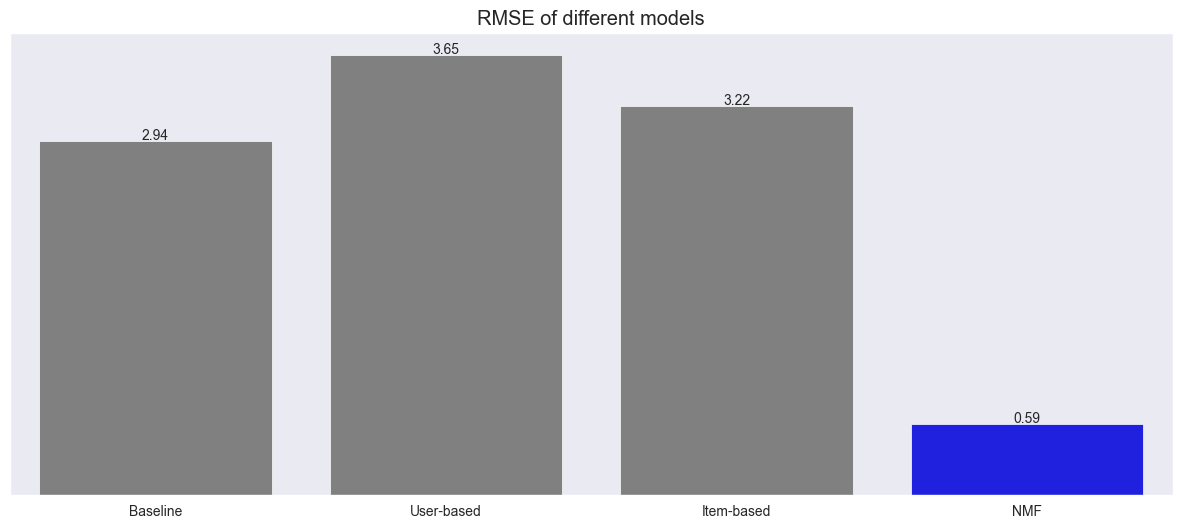

In [112]:
def error(matrix, prediction):
    return np.sqrt(np.mean((matrix-prediction)**2))
baseline_error = error(utility_matrix_train, baseline_model(utility_matrix_train))
user_based_error = error(utility_matrix_train, user_based_model(utility_matrix_train))
item_based_error = error(utility_matrix_train, item_based_model(utility_matrix_train))
nmf_error = error(utility_matrix_train, nmf_train)

print('Baseline model error: {:.2f}'.format(baseline_error))
print('User-based model error: {:.2f}'.format(user_based_error))
print('Item-based model error: {:.2f}'.format(item_based_error))
print('NMF model error: {:.2f}'.format(nmf_error))

errors = {'Baseline': baseline_error, 'User-based': user_based_error, 'Item-based': item_based_error, 'NMF': nmf_error}
plt.figure(figsize=(15, 6))
colors = ['gray' if (x > min(errors.values())) else 'blue' for x in errors.values()]
fig = sns.barplot(x=list(errors.keys()), y=list(errors.values()), palette=colors)
for patch in fig.patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+0.01,s='{:.2f}'.format(height), ha='center')
plt.title('RMSE of different models')
plt.tick_params(labelbottom=True, labelleft=False)


The best model is the NMF model with 20 latent features. Now we are going to find the optimal number of latent features.

In [115]:
utility_matrix_train[utility_matrix_train.index == 207].sum(axis=1)

user_id
207    0.0
dtype: float64

In [119]:
nmf_train[nmf_train.index == 207].sum(axis=1)

user_id
207    0.0
dtype: float64

In [120]:
utility_matrix_test[utility_matrix_test.index == 207].sum(axis=1)

user_id
207    81.0
dtype: float64